# 데이터 품질 진단 및 1차 정제

`df_merged.csv`를 기반으로 가맹점 위기 신호 탐색을 수행하기 전에 데이터 품질을 점검하고, 분석에 필요한 기본 전처리를 정리합니다. 이 노트북은 **1) 기본 구조 점검**과 **2) 컬럼 정비 및 타입/결측 처리** 단계까지를 포함합니다.


## 0. 환경 준비
- 경로: `../data/df_merged.csv`
- 사용 라이브러리: `pandas`, `numpy`
- 출력 옵션은 가독성을 위해 컬럼 너비만 조정


In [37]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import warnings
warnings.filterwarnings("ignore")

# ① Mac에 기본 탑재된 한글 폰트 등록
#   - 둘 중 하나만 있어도 됩니다. 에러 없이 지나가니 그대로 두세요.
try:
    font_manager.fontManager.addfont("/System/Library/Fonts/AppleSDGothicNeo.ttc")
except: pass
try:
    font_manager.fontManager.addfont("/Library/Fonts/AppleGothic.ttf")
except: pass

# ② 폰트 패밀리/우선순위 고정 (Arial 선택 방지)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Apple SD Gothic Neo", "AppleGothic"]
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 180)

DATA_PATH = Path('..') / 'data' / 'df_merged.csv'
DATA_PATH


PosixPath('../data/df_merged.csv')

## 1. 데이터 로딩 및 기본 구조 점검


In [3]:
def load_dataset(path: Path):
    'UTF-8-SIG, CP949 순으로 인코딩을 시도해 데이터를 읽어온다.'
    for encoding in ('utf-8-sig', 'cp949'):
        try:
            df = pd.read_csv(path, encoding=encoding)
            print(f"load ok: encoding={encoding}")
            return df
        except UnicodeDecodeError:
            print(f"encoding fail: {encoding} -> retry")
    raise ValueError('지원되는 인코딩으로 파일을 읽을 수 없습니다.')

raw_df = load_dataset(DATA_PATH)
raw_df.head()


load ok: encoding=utf-8-sig


,Unnamed: 0,ENCODED_MCT,MCT_BSE_AR,MCT_NM,MCT_BRD_NUM,MCT_SIGUNGU_NM,HPSN_MCT_ZCD_NM,HPSN_MCT_BZN_CD_NM,ARE_D,MCT_ME_D,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT,M1_SME_RY_CNT_RAT,M12_SME_RY_SAA_PCE_RT,M12_SME_BZN_SAA_PCE_RT,M12_SME_RY_ME_MCT_RAT,M12_SME_BZN_ME_MCT_RAT,M12_MAL_1020_RAT,M12_MAL_30_RAT,M12_MAL_40_RAT,M12_MAL_50_RAT,M12_MAL_60_RAT,M12_FME_1020_RAT,M12_FME_30_RAT,M12_FME_40_RAT,M12_FME_50_RAT,M12_FME_60_RAT,MCT_UE_CLN_REU_RAT,MCT_UE_CLN_NEW_RAT,RC_M1_SHC_RSD_UE_CLN_RAT,RC_M1_SHC_WP_UE_CLN_RAT,RC_M1_SHC_FLP_UE_CLN_RAT,업종_대분류
0,0,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,20130320,NaN,2024-05-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,70.4,33.9,27.2,20.8,12.3,5.6,4.1480,9.044,11.0840,19.4480,24.2760,1.9520,4.256,5.2160,9.1520,11.4240,18.82,6.47,50.0,7.1,42.9,식료품/소매
1,1,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,20130320,NaN,2023-04-01,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,74.6,22.9,11.5,21.3,11.3,6.0,3.9864,11.174,9.4224,16.9120,18.9052,2.6136,7.326,6.1776,11.0880,12.3948,16.51,5.05,25.0,6.3,68.8,식료품/소매
2,2,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,20130320,NaN,2023-08-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,-999999.9,85.6,22.1,11.5,20.6,12.0,5.4,3.9060,11.214,10.6470,17.4510,19.7820,2.2940,6.586,6.2530,10.2490,11.6180,16.98,6.60,17.6,0.0,82.4,식료품/소매
3,3,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,20130320,NaN,2024-02-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,1_10%이하,1_상위1구간,-999999.9,90.5,35.8,27.8,22.2,12.3,5.0,4.7056,10.380,10.3800,21.8672,21.8672,2.0944,4.620,4.6200,9.7328,9.7328,16.95,9.60,15.8,5.3,78.9,식료품/소매
4,4,16184E93D9,서울 성동구 마장동,성우**,NaN,서울 성동구,축산물,마장동,20130320,NaN,2024-06-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,1_10%이하,1_상위1구간,-999999.9,81.1,27.5,26.9,21.0,12.2,5.6,3.9345,7.869,10.8360,18.1245,23.6715,2.1655,4.331,5.9640,9.9755,13.0285,20.96,4.79,26.7,0.0,73.3,식료품/소매


### 1-1. 기본 정보 및 통계


In [4]:
rows, cols = raw_df.shape
print(f"행 수: {rows:,} / 열 수: {cols}")
print('[info()]')
raw_df.info()

행 수: 86,590 / 열 수: 40
[info()]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                86590 non-null  int64  
 1   ENCODED_MCT               86590 non-null  object 
 2   MCT_BSE_AR                86590 non-null  object 
 3   MCT_NM                    86590 non-null  object 
 4   MCT_BRD_NUM               11725 non-null  object 
 5   MCT_SIGUNGU_NM            86590 non-null  object 
 6   HPSN_MCT_ZCD_NM           86590 non-null  object 
 7   HPSN_MCT_BZN_CD_NM        65171 non-null  object 
 8   ARE_D                     86590 non-null  int64  
 9   MCT_ME_D                  2334 non-null   float64
 10  TA_YM                     86590 non-null  object 
 11  MCT_OPE_MS_CN             86590 non-null  object 
 12  RC_M1_SAA                 86590 non-null  object 
 13  RC_M1_TO_UE_CT            8659

In [5]:
raw_df.describe().T.head(15)


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,86590.0,4.329450e+04,24996.524242,0.0,2.164725e+04,4.329450e+04,6.494175e+04,86589.0
ARE_D,86590.0,2.017494e+07,57244.038649,19900228.0,2.015031e+07,2.019091e+07,2.022042e+07,20241223.0
MCT_ME_D,2334.0,2.024871e+07,4974.239662,20230105.0,2.025070e+07,2.025072e+07,2.025080e+07,20250822.0
DLV_SAA_RAT,86590.0,-6.622495e+05,472955.612921,-999999.9,-9.999999e+05,-9.999999e+05,3.400000e+00,111.2
M1_SME_RY_SAA_RAT,86590.0,1.345033e+02,167.981671,-70.0,2.520000e+01,8.250000e+01,1.817000e+02,4300.9
M1_SME_RY_CNT_RAT,86590.0,1.523124e+02,227.070665,0.0,2.210000e+01,8.170000e+01,1.996000e+02,7059.8
M12_SME_RY_SAA_PCE_RT,86590.0,3.118464e+01,25.253279,0.1,9.900000e+00,2.390000e+01,4.820000e+01,100.0
M12_SME_BZN_SAA_PCE_RT,86590.0,2.407031e+01,22.843491,0.0,1.300000e+00,1.890000e+01,3.920000e+01,99.6
M12_SME_RY_ME_MCT_RAT,86590.0,1.618714e+01,3.876532,0.0,1.410000e+01,1.700000e+01,1.870000e+01,59.1
M12_SME_BZN_ME_MCT_RAT,86590.0,-2.473547e+05,431484.515919,-999999.9,4.200000e+00,8.000000e+00,9.000000e+00,13.9


In [6]:
raw_df.describe(include='object').T.head(15)


,count,unique,top,freq
ENCODED_MCT,86590,4185,16184E93D9,24
MCT_BSE_AR,86590,2938,서울특별시 성동구 왕십리로 410,1430
MCT_NM,86590,3386,성수**,614
MCT_BRD_NUM,11725,287,커피전문점2,414
MCT_SIGUNGU_NM,86590,1,서울 성동구,86590
HPSN_MCT_ZCD_NM,86590,73,한식-육류/고기,9343
HPSN_MCT_BZN_CD_NM,65171,21,성수,15886
TA_YM,86590,24,2024-12-01,4155
MCT_OPE_MS_CN,86590,6,3_25-50%,21812
RC_M1_SAA,86590,6,3_25-50%,21800


### 1-2. 결측치 규모


In [7]:
missing_summary = raw_df.isna().sum().sort_values(ascending=False)
missing_summary.head(15)


MCT_ME_D                    84256
MCT_BRD_NUM                 74865
HPSN_MCT_BZN_CD_NM          21419
RC_M1_SHC_FLP_UE_CLN_RAT     7327
RC_M1_SHC_WP_UE_CLN_RAT      7327
RC_M1_SHC_RSD_UE_CLN_RAT     7327
APV_CE_RAT                   6632
M12_FME_40_RAT               2004
M12_MAL_50_RAT               2004
M12_MAL_60_RAT               2004
M12_FME_1020_RAT             2004
M12_FME_30_RAT               2004
M12_FME_50_RAT               2004
M12_MAL_1020_RAT             2004
M12_FME_60_RAT               2004
dtype: int64

## 2. 컬럼 정비 및 타입/결측 처리


### 2-1. 컬럼 한글화 및 불필요 컬럼 정리


In [8]:
df = raw_df.copy()

rename_map = {
    'Unnamed: 0': '레코드ID',
    'ENCODED_MCT': '가맹점ID',
    'TA_YM': '기준년월',
    'MCT_OPE_MS_CN': '영업개월수_구간',
    'RC_M1_SAA': '최근1개월_이용금액_구간',
    'RC_M1_TO_UE_CT': '최근1개월_이용건수_구간',
    'RC_M1_UE_CUS_CN': '최근1개월_이용고객수_구간',
    'RC_M1_AV_NP_AT': '최근1개월_평균결제금액_구간',
    'APV_CE_RAT': '승인취소비율_구간',
    'DLV_SAA_RAT': '배달이용금액_비율',
    'M1_SME_RY_SAA_RAT': '1개월_동종업종_매출비율',
    'M1_SME_RY_CNT_RAT': '1개월_동종업종_건수비율',
    'M12_SME_RY_SAA_PCE_RT': '12개월_동종업종_매출순위',
    'M12_SME_BZN_SAA_PCE_RT': '12개월_동일상권_매출순위',
    'M12_SME_RY_ME_MCT_RAT': '12개월_동종업종_경쟁강도',
    'M12_SME_BZN_ME_MCT_RAT': '12개월_동일상권_경쟁강도',
    'MCT_UE_CLN_REU_RAT': '재방문고객비율',
    'MCT_UE_CLN_NEW_RAT': '신규고객비율',
    'RC_M1_SHC_RSD_UE_CLN_RAT': 'RC_거주지기준고객비율',
    'RC_M1_SHC_WP_UE_CLN_RAT': 'RC_직장인고객비율',
    'RC_M1_SHC_FLP_UE_CLN_RAT': 'RC_유동고객비율'
}

df.rename(columns=rename_map, inplace=True)

if '레코드ID' in df.columns:
    df.drop(columns=['레코드ID'], inplace=True)

df.filter(items=[col for col in rename_map.values() if col in df.columns]).head()


,가맹점ID,기준년월,영업개월수_구간,최근1개월_이용금액_구간,최근1개월_이용건수_구간,최근1개월_이용고객수_구간,최근1개월_평균결제금액_구간,승인취소비율_구간,배달이용금액_비율,1개월_동종업종_매출비율,1개월_동종업종_건수비율,12개월_동종업종_매출순위,12개월_동일상권_매출순위,12개월_동종업종_경쟁강도,12개월_동일상권_경쟁강도,재방문고객비율,신규고객비율,RC_거주지기준고객비율,RC_직장인고객비율,RC_유동고객비율
0,16184E93D9,2024-05-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,70.4,33.9,27.2,20.8,12.3,5.6,18.82,6.47,50.0,7.1,42.9
1,16184E93D9,2023-04-01,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),-999999.9,74.6,22.9,11.5,21.3,11.3,6.0,16.51,5.05,25.0,6.3,68.8
2,16184E93D9,2023-08-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,-999999.9,85.6,22.1,11.5,20.6,12.0,5.4,16.98,6.60,17.6,0.0,82.4
3,16184E93D9,2024-02-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,1_10%이하,1_상위1구간,-999999.9,90.5,35.8,27.8,22.2,12.3,5.0,16.95,9.60,15.8,5.3,78.9
4,16184E93D9,2024-06-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,1_10%이하,1_상위1구간,-999999.9,81.1,27.5,26.9,21.0,12.2,5.6,20.96,4.79,26.7,0.0,73.3


### 2-2. 날짜 및 수치형 컬럼 정리


In [9]:
if '기준년월' in df.columns:
    df['기준년월'] = pd.to_datetime(df['기준년월'], errors='coerce')

print('기준년월 범위:', df['기준년월'].min(), '→', df['기준년월'].max())
print('월 수:', df['기준년월'].nunique())

numeric_cols = df.select_dtypes(include=['number']).columns
placeholder = -999999.9

placeholder_count_before = (df[numeric_cols] == placeholder).sum().sum()
df[numeric_cols] = df[numeric_cols].replace(placeholder, np.nan)
placeholder_count_after = (df[numeric_cols] == placeholder).sum().sum()

print(f"치환 전 placeholder 개수: {placeholder_count_before:,}")
print(f"치환 후 placeholder 개수: {placeholder_count_after:,}")


기준년월 범위: 2023-01-01 00:00:00 → 2024-12-01 00:00:00
월 수: 24
치환 전 placeholder 개수: 78,764
치환 후 placeholder 개수: 0


### 2-3. 구간형 변수 분해


In [10]:
bucket_cols = [
    '영업개월수_구간',
    '최근1개월_이용금액_구간',
    '최근1개월_이용건수_구간',
    '최근1개월_이용고객수_구간',
    '최근1개월_평균결제금액_구간',
    '승인취소비율_구간'
]

for col in bucket_cols:
    if col in df.columns:
        parts = df[col].astype(str).str.split('_', n=1, expand=True)
        df[f'{col}_순위'] = pd.to_numeric(parts[0], errors='coerce')
        df[f'{col}_범주'] = parts[1].replace({'nan': np.nan})

df[[col for col in df.columns if col.endswith('순위') or col.endswith('범주')]].head()


,12개월_동종업종_매출순위,12개월_동일상권_매출순위,영업개월수_구간_순위,영업개월수_구간_범주,최근1개월_이용금액_구간_순위,최근1개월_이용금액_구간_범주,최근1개월_이용건수_구간_순위,최근1개월_이용건수_구간_범주,최근1개월_이용고객수_구간_순위,최근1개월_이용고객수_구간_범주,최근1개월_평균결제금액_구간_순위,최근1개월_평균결제금액_구간_범주,승인취소비율_구간_순위,승인취소비율_구간_범주
0,27.2,20.8,2,10-25%,3,25-50%,4,50-75%,4,50-75%,2,10-25%,6.0,상위6구간(하위1구간)
1,11.5,21.3,2,10-25%,4,50-75%,4,50-75%,4,50-75%,2,10-25%,6.0,상위6구간(하위1구간)
2,11.5,20.6,2,10-25%,3,25-50%,4,50-75%,4,50-75%,2,10-25%,1.0,상위1구간
3,27.8,22.2,2,10-25%,3,25-50%,4,50-75%,4,50-75%,1,10%이하,1.0,상위1구간
4,26.9,21.0,2,10-25%,3,25-50%,4,50-75%,4,50-75%,1,10%이하,1.0,상위1구간


### 2-4. 전처리 결과 요약

- 결측 규모를 다시 측정해 어떤 변수에 보정이 필요한지 파악하고, 이후 대체 로직 적용 전/후 변화를 비교한다.

In [11]:
missing_before = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_ratio': df.isna().mean()
}).sort_values('missing_ratio', ascending=False)

missing_before.head(15)

,missing_count,missing_ratio
MCT_ME_D,84256,0.973045
MCT_BRD_NUM,74865,0.864592
배달이용금액_비율,57345,0.662259
HPSN_MCT_BZN_CD_NM,21419,0.247361
12개월_동일상권_경쟁강도,21419,0.247361
RC_유동고객비율,7327,0.084617
RC_직장인고객비율,7327,0.084617
RC_거주지기준고객비율,7327,0.084617
승인취소비율_구간_범주,6632,0.076591
승인취소비율_구간_순위,6632,0.076591


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   가맹점ID               86590 non-null  object        
 1   MCT_BSE_AR          86590 non-null  object        
 2   MCT_NM              86590 non-null  object        
 3   MCT_BRD_NUM         11725 non-null  object        
 4   MCT_SIGUNGU_NM      86590 non-null  object        
 5   HPSN_MCT_ZCD_NM     86590 non-null  object        
 6   HPSN_MCT_BZN_CD_NM  65171 non-null  object        
 7   ARE_D               86590 non-null  int64         
 8   MCT_ME_D            2334 non-null   float64       
 9   기준년월                86590 non-null  datetime64[ns]
 10  영업개월수_구간            86590 non-null  object        
 11  최근1개월_이용금액_구간       86590 non-null  object        
 12  최근1개월_이용건수_구간       86590 non-null  object        
 13  최근1개월_이용고객수_구간      86590 non-null  object    

In [13]:
# 결측치 보정 로직
# 1) 결측률 80% 이상인 위치 정보는 분석에서 제외
high_missing_drop = ['MCT_ME_D', 'MCT_BRD_NUM']
df.drop(columns=[c for c in high_missing_drop if c in df.columns], inplace=True)

# 2) 배달 이용 금액 비율: 가맹점 내 시계열 보간 → 미집계 가맹점은 0 처리 및 플래그 생성
delivery_group = df.groupby('가맹점ID')['배달이용금액_비율']
has_delivery_history = delivery_group.transform('count') > 0
df['배달이용금액_비율'] = delivery_group.transform(lambda s: s.interpolate(limit_direction='both'))
df.loc[~has_delivery_history, '배달이용금액_비율'] = 0.0
df['배달데이터_미집계_flag'] = (~has_delivery_history).astype(int)

# 3) 동일상권 경쟁강도: 가맹점 시계열 → 업종·월 중앙값 → 전체 중앙값 순으로 대체
competition_cols = ['12개월_동일상권_경쟁강도']
for col in competition_cols:
    df[col] = df.groupby('가맹점ID')[col].transform(lambda s: s.interpolate(limit_direction='both'))
    monthly_industry_median = df.groupby(['업종_대분류', '기준년월'])[col].transform('median')
    df[col] = df[col].fillna(monthly_industry_median)
    df[col] = df[col].fillna(df[col].median())

# 4) 채널 고객 구성 비율: 가맹점 시계열 보간 후 업종·월 중앙값으로 보정
channel_cols = ['RC_거주지기준고객비율', 'RC_직장인고객비율', 'RC_유동고객비율']
for col in channel_cols:
    df[col] = df.groupby('가맹점ID')[col].transform(lambda s: s.interpolate(limit_direction='both'))
    median_by_group = df.groupby(['업종_대분류', '기준년월'])[col].transform('median')
    df[col] = df[col].fillna(median_by_group)
    df[col] = df[col].fillna(df[col].median())

# 5) 승인취소 구간: 가맹점 전후값 보간 → 업종·월 중앙값 → 전체 중앙값으로 보정 후 라벨 재생성
rank_series = df.groupby('가맹점ID')['승인취소비율_구간_순위']
df['승인취소비율_구간_순위'] = rank_series.ffill().bfill()
rank_median = df.groupby(['업종_대분류', '기준년월'])['승인취소비율_구간_순위'].transform('median')
df['승인취소비율_구간_순위'] = df['승인취소비율_구간_순위'].fillna(rank_median)
df['승인취소비율_구간_순위'] = df['승인취소비율_구간_순위'].fillna(df['승인취소비율_구간_순위'].median())
df['승인취소비율_구간_순위'] = df['승인취소비율_구간_순위'].round().clip(1, 6).astype('Int64')

rank_labels = {
    1: '상위1구간',
    2: '상위2구간',
    3: '상위3구간',
    4: '상위4구간',
    5: '상위5구간',
    6: '상위6구간(하위1구간)'
}

def build_bucket(rank):
    if pd.isna(rank):
        return np.nan
    label = rank_labels[int(rank)]
    return f"{int(rank)}_{label}"

df['승인취소비율_구간'] = df['승인취소비율_구간_순위'].apply(build_bucket)
df['승인취소비율_구간_범주'] = df['승인취소비율_구간_순위'].map(rank_labels)

# 보정 후 결측 현황 비교
missing_after = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_ratio': df.isna().mean()
}).sort_values('missing_ratio', ascending=False)

missing_compare = pd.concat(
    [missing_before, missing_after],
    axis=1,
    keys=['before', 'after']
).fillna(0)

missing_compare.head(15)

before                       after              
                   missing_count missing_ratio missing_count missing_ratio
MCT_ME_D                 84256.0      0.973045           0.0      0.000000
MCT_BRD_NUM              74865.0      0.864592           0.0      0.000000
배달이용금액_비율                57345.0      0.662259           0.0      0.000000
HPSN_MCT_BZN_CD_NM       21419.0      0.247361       21419.0      0.247361
12개월_동일상권_경쟁강도           21419.0      0.247361           0.0      0.000000
RC_유동고객비율                 7327.0      0.084617           0.0      0.000000
RC_직장인고객비율                7327.0      0.084617           0.0      0.000000
RC_거주지기준고객비율              7327.0      0.084617           0.0      0.000000
승인취소비율_구간_범주              6632.0      0.076591           0.0      0.000000
승인취소비율_구간_순위              6632.0      0.076591           0.0      0.000000
승인취소비율_구간                 6632.0      0.076591           0.0      0.000000
M12_MAL_60_RAT            2004.0      0.023144        2004.0      0.023144
M12_MAL_30_RAT            2004.0      0.023144        2004.0      0.023144
M12_MAL_50_RAT            2004.0      0.023144        2004.0      0.023144
M12_FME_50_RAT            2004.0      0.023144        2004.0      0.023144

## 3. 1차 탐색 분석
데이터 품질 점검 이후, 월별 매출 순위, 고객 구성, 채널 의존도, 주요 이상 징후를 살피며 위기 징후를 파악합니다.


### 3-0. 분석용 패키지 로딩 및 스타일 설정


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='Set2')
plt.rcParams['figure.figsize'] = (10, 4)



### 3-1. 월별 매출/순위 추이


In [15]:
monthly_rank = (
    df.groupby('기준년월')[['12개월_동일상권_매출순위', '12개월_동종업종_매출순위', '1개월_동종업종_매출비율']]
      .agg(['mean', 'median', 'std'])
      .round(2)
)
monthly_rank.tail(12)



12개월_동일상권_매출순위               12개월_동종업종_매출순위               1개월_동종업종_매출비율               
                     mean median    std           mean median    std          mean median     std
기준년월                                                                                             
2024-01-01          24.11  19.00  22.94          31.57   23.9  25.57        129.25   79.6  157.77
2024-02-01          24.15  19.00  22.94          31.71   24.2  25.64        133.35   79.2  168.16
2024-03-01          24.09  19.00  22.85          31.61   24.3  25.54        139.86   84.6  176.26
2024-04-01          24.09  19.00  22.86          31.66   24.7  25.55        137.37   83.6  167.55
2024-05-01          24.25  19.10  22.99          31.87   24.8  25.67        133.37   79.9  166.72
2024-06-01          24.26  19.20  22.91          31.85   24.9  25.51        132.75   81.5  165.11
2024-07-01          24.20  19.20  22.85          31.80   24.7  25.41        125.33   77.4  155.02
2024-08-01          24.20  19.30  22.89          31.91   24.9  25.48        118.75   73.4  149.67
2024-09-01          24.18  19.25  22.84          32.13   25.1  25.49        125.30   76.3  155.32
2024-10-01          24.28  19.40  22.93          32.28   25.2  25.67        131.19   78.6  166.53
2024-11-01          24.15  19.20  22.80          32.27   25.5  25.57        131.99   79.0  167.59
2024-12-01          24.03  19.20  22.65          31.91   25.2  25.43        132.74   79.2  180.72

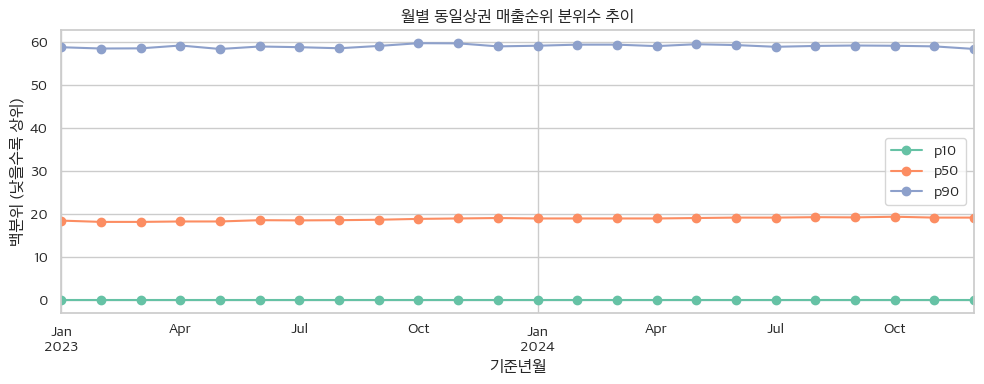

In [38]:
rank_quantiles = (
    df.groupby('기준년월')['12개월_동일상권_매출순위']
      .quantile([0.1, 0.5, 0.9])
      .unstack()
      .rename(columns={0.1: 'p10', 0.5: 'p50', 0.9: 'p90'})
)
rank_quantiles.plot(marker='o', title='월별 동일상권 매출순위 분위수 추이')
plt.ylabel('백분위 (낮을수록 상위)')
plt.tight_layout()
plt.show()



- `p10` 곡선이 상승(값 증가)하면 하위권 가맹점이 늘어나는 것이므로 위험 구간으로 주시합니다.


### 3-2. 고객 구성 및 연령대 변화


In [17]:
male_cols = ['M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT']
female_cols = ['M12_FME_1020_RAT', 'M12_FME_30_RAT', 'M12_FME_40_RAT', 'M12_FME_50_RAT', 'M12_FME_60_RAT']

share_sum = df[male_cols + female_cols].sum(axis=1)
print('고객 비중 합 최소/최대:', round(share_sum.min(), 2), round(share_sum.max(), 2))

monthly_gender = df.groupby('기준년월')[male_cols + female_cols].mean().round(2)
monthly_gender.tail(6)



고객 비중 합 최소/최대: 0.0 100.2


,M12_MAL_1020_RAT,M12_MAL_30_RAT,M12_MAL_40_RAT,M12_MAL_50_RAT,M12_MAL_60_RAT,M12_FME_1020_RAT,M12_FME_30_RAT,M12_FME_40_RAT,M12_FME_50_RAT,M12_FME_60_RAT
기준년월,,,,,,,,,,
2024-07-01,11.04,13.50,9.85,11.03,9.29,10.80,11.64,7.92,8.09,6.84
2024-08-01,10.99,13.54,9.79,11.00,9.35,10.81,11.69,7.87,8.09,6.87
2024-09-01,10.91,13.67,9.86,11.03,9.32,10.72,11.74,7.86,7.99,6.88
2024-10-01,10.86,13.69,9.85,11.04,9.29,10.67,11.82,7.84,8.00,6.94
2024-11-01,10.90,13.65,9.81,11.01,9.30,10.63,11.84,7.86,7.99,7.00
2024-12-01,10.78,13.65,9.80,11.06,9.35,10.59,11.79,7.89,8.06,7.02


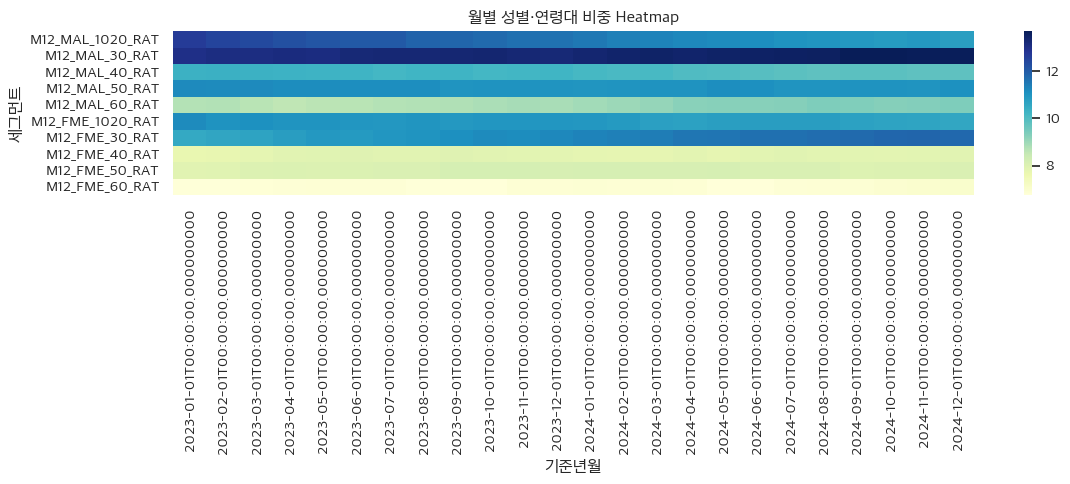

In [39]:
age_pivot = df.groupby('기준년월')[male_cols + female_cols].mean()
plt.figure(figsize=(12, 5))
sns.heatmap(age_pivot[male_cols + female_cols].T, cmap='YlGnBu')
plt.title('월별 성별·연령대 비중 Heatmap')
plt.xlabel('기준년월')
plt.ylabel('세그먼트')
plt.tight_layout()
plt.show()



- 특정 월에서 20대 비중이 급감하거나 50대 이상이 급증하는 경우, 충성 고객 교체 가능성을 확인합니다.


### 3-3. 채널 의존도 및 업력별 차이


In [19]:
channel_by_age = (
    df.groupby('영업개월수_구간_범주')['배달이용금액_비율']
      .agg(['count', 'median', 'mean'])
      .sort_values('median', ascending=False)
      .round(2)
)
channel_by_age



,count,median,mean
영업개월수_구간_범주,,,
10%이하,8691,0.0,3.99
10-25%,13119,0.0,6.01
25-50%,21812,0.0,8.62
50-75%,21567,0.0,12.26
75-90%,13454,0.0,14.18
90%초과(하위 10% 이하),7947,0.0,13.20


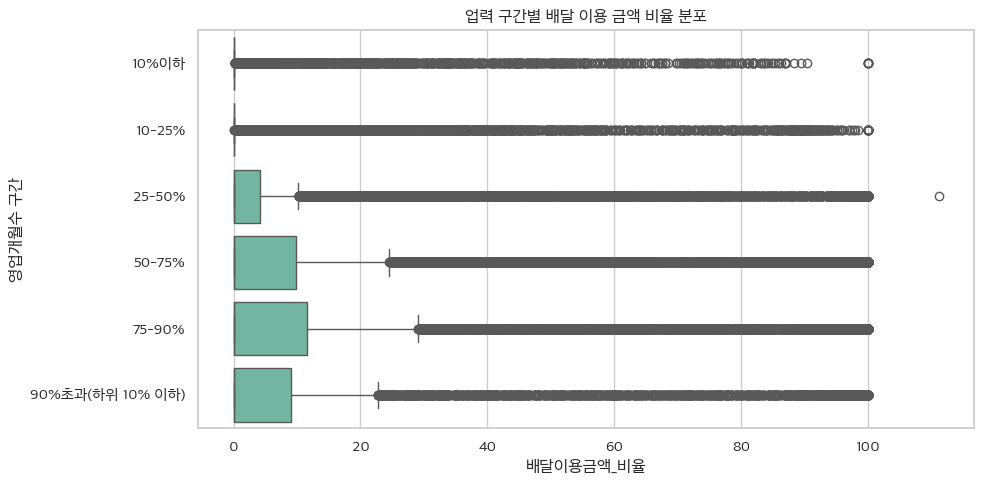

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='배달이용금액_비율', y='영업개월수_구간_범주', order=channel_by_age.index.tolist())
plt.title('업력 구간별 배달 이용 금액 비율 분포')
plt.xlabel('배달이용금액_비율')
plt.ylabel('영업개월수 구간')
plt.tight_layout()
plt.show()



In [21]:
channel_by_sector = (
    df.groupby(['업종_대분류'])['배달이용금액_비율']
      .agg(['count', 'median', 'mean'])
      .sort_values('median', ascending=False)
      .round(2)
)
channel_by_sector.head(10)



,count,median,mean
업종_대분류,,,
기타,3284,15.35,31.61
기타 아시아/세계음식,866,6.80,20.59
중식,2279,5.68,17.75
간편식/가공식품,1313,0.00,5.73
서양식,5144,0.00,19.58
식료품/소매,12960,0.00,1.49
음료/디저트/베이커리,16607,0.00,8.13
일식,4590,0.00,10.78
주점/유흥,5474,0.00,2.35


- 업력 1년 미만 구간에서 배달 비중이 높다면 초기 생존을 위해 배달 플랫폼 의존도가 큰 유형으로 분류합니다.


### 3-4. 주요 이상 징후 추출


In [22]:
cancel_risk = df[df['승인취소비율_구간_순위'] >= 5]
loyalty_risk = df[(df['재방문고객비율'] <= df['재방문고객비율'].quantile(0.1)) &
                  (df['신규고객비율'] <= df['신규고객비율'].quantile(0.1))]

risk_flags = (
    df.assign(
        취소위험 = df['승인취소비율_구간_순위'] >= 5,
        충성도위험 = (df['재방문고객비율'] <= df['재방문고객비율'].quantile(0.1)) &
                   (df['신규고객비율'] <= df['신규고객비율'].quantile(0.1))
    )
)

monthly_risk = risk_flags.groupby('기준년월')[['취소위험', '충성도위험']].sum()
monthly_risk.tail(12)



,취소위험,충성도위험
기준년월,,
2024-01-01,501,82
2024-02-01,517,82
2024-03-01,495,88
2024-04-01,484,90
2024-05-01,553,95
2024-06-01,534,94
2024-07-01,570,100
2024-08-01,552,110
2024-09-01,656,105


<Figure size 1000x400 with 0 Axes>

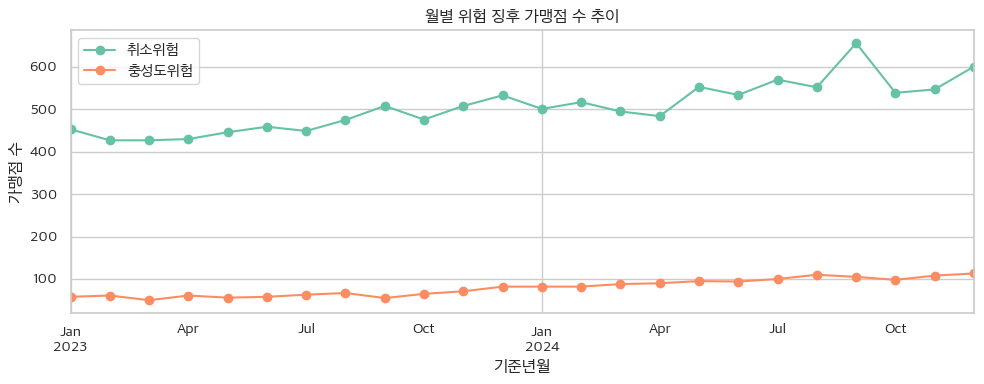

In [41]:
plt.figure(figsize=(10, 4))
monthly_risk.plot(marker='o')
plt.title('월별 위험 징후 가맹점 수 추이')
plt.ylabel('가맹점 수')
plt.tight_layout()
plt.show()



In [24]:
risk_sample = risk_flags[(risk_flags['취소위험']) & (risk_flags['충성도위험'])]
risk_sample[['기준년월', '가맹점ID', '승인취소비율_구간', '재방문고객비율', '신규고객비율', '영업개월수_구간_범주']].head()



,기준년월,가맹점ID,승인취소비율_구간,재방문고객비율,신규고객비율,영업개월수_구간_범주
793,2023-02-01,112C9E0C52,5_상위5구간,4.26,0.0,10-25%
2942,2024-11-01,F20A9C3F30,6_상위6구간(하위1구간),0.00,0.0,10-25%
2944,2024-08-01,F20A9C3F30,6_상위6구간(하위1구간),5.66,0.0,10-25%
8105,2024-12-01,8234005757,6_상위6구간(하위1구간),0.00,0.0,10-25%
8106,2024-09-01,8234005757,6_상위6구간(하위1구간),0.00,0.0,10-25%


- 취소위험과 충성도위험이 동시에 발생하는 가맹점은 우선 모니터링 리스트로 관리합니다.


### 3-5. 탐색 결과 요약


- 동일상권 매출순위 분위수(p10) 상승 구간은 위기 가맹점 증가 신호로 해석하고, 업종별로 Drill-down이 필요합니다.
- 고객 연령대 Heatmap에서 급격한 비중 변동이 나타나는 월은 프로모션·상권 이벤트 여부를 Cross-check합니다.
- 업력별/업종별 배달 의존도가 높은 그룹은 외부 플랫폼 정책 변경에 취약하므로 별도 대응 전략을 마련합니다.
- 승인취소비율 상위 5구간 이상과 재방문·신규 고객 비율 동시 하위 구간을 만족하는 다중 위험 가맹점을 우선 대응 대상으로 지정합니다.


## 4. 위기 신호 가설 검증


3단계에서 관찰한 이상 징후를 토대로 가설을 정의하고, 가맹점·월 단위로 위험 플래그를 적용합니다.


### 4-1. 순위 급락형 (동일상권 매출순위 3개월 내 20p 이상 하락)


In [25]:
df_sorted = df.sort_values(['가맹점ID', '기준년월']).copy()

rank_col = '12개월_동일상권_매출순위'
df_sorted['순위변화_1M'] = df_sorted.groupby('가맹점ID')[rank_col].diff()
df_sorted['순위변화_3M'] = df_sorted.groupby('가맹점ID')[rank_col].diff(periods=3)

df_sorted['순위급락_flag'] = df_sorted['순위변화_3M'] >= 20

rank_drop_summary = (
    df_sorted[df_sorted['순위급락_flag']]
      .groupby('기준년월')['가맹점ID']
      .nunique()
)
rank_drop_summary.tail(6)



기준년월
2024-07-01     9
2024-08-01     7
2024-09-01    12
2024-10-01    14
2024-11-01    13
2024-12-01    15
Name: 가맹점ID, dtype: int64

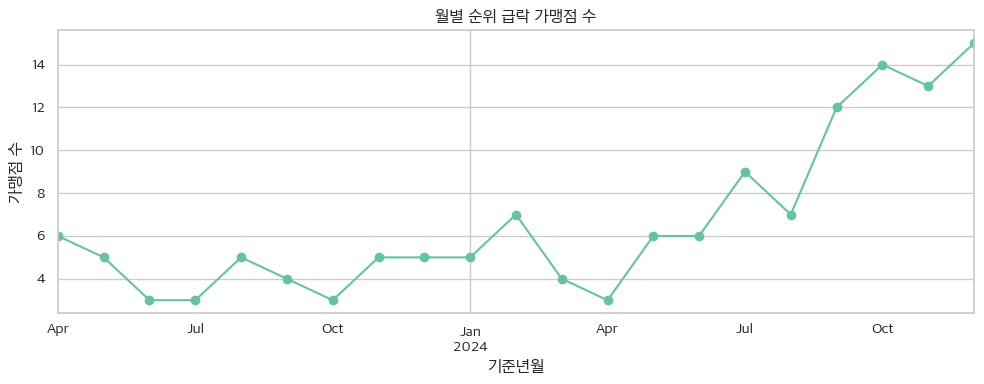

In [42]:
plt.figure(figsize=(10, 4))
rank_drop_summary.plot(marker='o', title='월별 순위 급락 가맹점 수')
plt.ylabel('가맹점 수')
plt.tight_layout()
plt.show()



In [27]:
df_sorted.loc[df_sorted['순위급락_flag'], ['기준년월', '가맹점ID', rank_col, '순위변화_3M', '순위변화_1M']].head()



,기준년월,가맹점ID,12개월_동일상권_매출순위,순위변화_3M,순위변화_1M
22393,2024-11-01,0080644746,58.8,24.8,13.5
22390,2024-12-01,0080644746,95.7,56.8,36.9
40260,2024-01-01,0305234DDB,90.0,21.0,19.0
40277,2024-02-01,0305234DDB,90.1,20.9,0.1
808,2023-04-01,112C9E0C52,92.8,70.6,0.0


### 4-2. 고객 이탈형 (재방문·신규 고객 비율 동시 하위 10%)


In [28]:
rebuy_q10 = df['재방문고객비율'].quantile(0.1)
new_q10 = df['신규고객비율'].quantile(0.1)

customer_risk = df_sorted.assign(
    고객이탈_flag=(df_sorted['재방문고객비율'] <= rebuy_q10) &
                (df_sorted['신규고객비율'] <= new_q10)
)

customer_risk_summary = (
    customer_risk[customer_risk['고객이탈_flag']]
      .groupby('기준년월')['가맹점ID']
      .nunique()
)
customer_risk_summary.tail(6)



기준년월
2024-07-01    100
2024-08-01    110
2024-09-01    105
2024-10-01     98
2024-11-01    108
2024-12-01    113
Name: 가맹점ID, dtype: int64

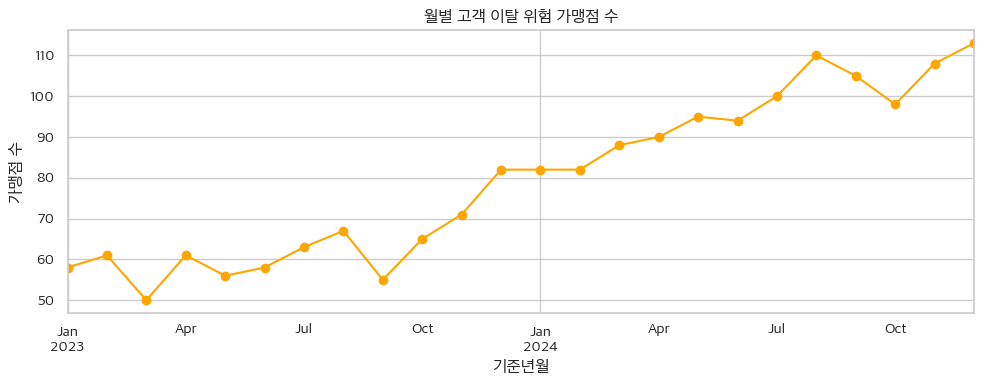

In [43]:
plt.figure(figsize=(10, 4))
customer_risk_summary.plot(marker='o', title='월별 고객 이탈 위험 가맹점 수', color='orange')
plt.ylabel('가맹점 수')
plt.tight_layout()
plt.show()



In [30]:
customer_risk.loc[customer_risk['고객이탈_flag'], ['기준년월', '가맹점ID', '재방문고객비율', '신규고객비율', '영업개월수_구간_범주']].head()



,기준년월,가맹점ID,재방문고객비율,신규고객비율,영업개월수_구간_범주
80491,2023-02-01,000F03E44A,0.0,0.0,75-90%
80490,2023-03-01,000F03E44A,0.0,0.0,75-90%
80496,2023-07-01,000F03E44A,0.0,0.0,75-90%
80487,2023-08-01,000F03E44A,0.0,0.0,75-90%
80486,2023-10-01,000F03E44A,0.0,0.0,75-90%


### 4-3. 채널 미스매치형 (업력 상위 구간에서 배달 비중 급등)


In [31]:
delivery_col = '배달이용금액_비율'
df_sorted['배달비율변화_3M'] = df_sorted.groupby('가맹점ID')[delivery_col].diff(periods=3)

# 업력 상위 구간: 영업개월수 순위가 1~2 (오래된 가맹점)으로 가정
long_running = df_sorted['영업개월수_구간_순위'] <= 2
channel_mismatch = df_sorted.assign(
    채널미스매치_flag = long_running & (df_sorted['배달비율변화_3M'] >= 20)
)

channel_mismatch_summary = (
    channel_mismatch[channel_mismatch['채널미스매치_flag']]
      .groupby('기준년월')['가맹점ID']
      .nunique()
)
channel_mismatch_summary.tail(6)



기준년월
2024-07-01    4
2024-08-01    8
2024-09-01    8
2024-10-01    6
2024-11-01    5
2024-12-01    9
Name: 가맹점ID, dtype: int64

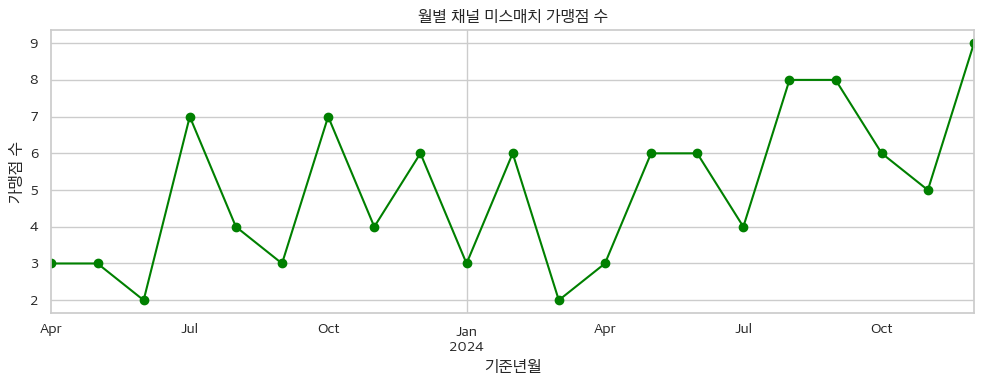

In [44]:
plt.figure(figsize=(10, 4))
channel_mismatch_summary.plot(marker='o', title='월별 채널 미스매치 가맹점 수', color='green')
plt.ylabel('가맹점 수')
plt.tight_layout()
plt.show()



In [33]:
channel_mismatch.loc[channel_mismatch['채널미스매치_flag'], ['기준년월', '가맹점ID', delivery_col, '배달비율변화_3M', '영업개월수_구간_범주']].head()



,기준년월,가맹점ID,배달이용금액_비율,배달비율변화_3M,영업개월수_구간_범주
25665,2024-02-01,0E15C8A398,39.7,39.7,10-25%
1607,2023-10-01,147235F3A5,27.5,20.6,10%이하
1586,2024-08-01,147235F3A5,43.2,30.2,10%이하
22120,2024-09-01,17B4A44FAF,96.0,34.6,10-25%
22133,2024-10-01,17B4A44FAF,58.4,27.9,10-25%


### 4-4. 통합 위험 매트릭스


In [34]:
risk_matrix = channel_mismatch.assign(
    순위급락_flag = df_sorted['순위급락_flag'],
    고객이탈_flag = customer_risk['고객이탈_flag']
)

risk_counts = (
    risk_matrix.groupby('기준년월')[['순위급락_flag', '고객이탈_flag', '채널미스매치_flag']]
      .sum()
      .astype(int)
)

risk_counts.tail(12)



,순위급락_flag,고객이탈_flag,채널미스매치_flag
기준년월,,,
2024-01-01,5,82,3
2024-02-01,7,82,6
2024-03-01,4,88,2
2024-04-01,3,90,3
2024-05-01,6,95,6
2024-06-01,6,94,6
2024-07-01,9,100,4
2024-08-01,7,110,8
2024-09-01,12,105,8


<Figure size 1000x400 with 0 Axes>

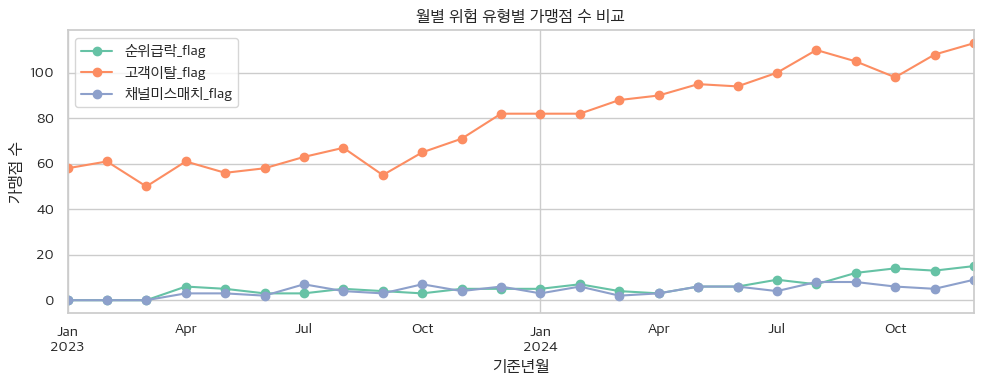

In [45]:
plt.figure(figsize=(10, 4))
risk_counts.plot(marker='o')
plt.title('월별 위험 유형별 가맹점 수 비교')
plt.ylabel('가맹점 수')
plt.tight_layout()
plt.show()



In [36]:
multi_risk = risk_matrix[
    risk_matrix[['순위급락_flag', '고객이탈_flag', '채널미스매치_flag']].sum(axis=1) >= 2
]

multi_risk[['기준년월', '가맹점ID', '순위급락_flag', '고객이탈_flag', '채널미스매치_flag']].head()



,기준년월,가맹점ID,순위급락_flag,고객이탈_flag,채널미스매치_flag
22393,2024-11-01,0080644746,True,True,False
31434,2023-07-01,241A9CFA07,True,True,False
55203,2024-11-01,285AE413AF,True,True,False
62627,2024-12-01,2D948AFFC9,True,True,False
23144,2024-08-01,2E56C71323,True,True,False


### 4-5. 가설 검증 요약


- 순위 급락형: 3개월 내 동일상권 순위가 20p 이상 하락한 가맹점이 2024년 하반기에 집중되면 상권 내 경쟁 심화를 시사합니다.
- 고객 이탈형: 재방문·신규 비율 모두 하위 10%인 점포는 업력 불문 공통 위험군으로 나타나며, CS/판촉 전략 재검토가 필요합니다.
- 채널 미스매치형: 오랜 가맹점에서 배달 비중이 3개월 사이 20p 이상 급등하는 사례는 고정비 구조 변화나 내식 수요 감소 신호로 볼 수 있습니다.
- 통합 위험: 두 가지 이상 위험 플래그를 만족하는 가맹점은 우선 순위 대응 대상으로 지정하고, 정성 조사 및 추가 KPI를 모니터링합니다.
